# Build the kinematic model based on collected data

Build a model that predicts the pose (position or configuration) of the soft arm from the motor commands (actuation inputs).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
import joblib
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# Load the saved dataset in a_files
data = np.load("data_optitrack/data9000_actrange150_date1004_1.npz")

# List all arrays stored inside
print(data.files)
files = data.files

['actual_position_list', 'act_list', 'wanted_position_list']


In [3]:
for file in files:
    print(f"{file}: {data[file].shape}")

actual_position_list: (9000, 3, 3)
act_list: (9000, 3, 3)
wanted_position_list: (9000, 3, 3)


In [4]:
print("actual_position_list:") 
print(data["actual_position_list"][0:5])
print("wanted_position_list:")
print(data["wanted_position_list"][0:5])
print("act_list:")
print(data["act_list"][0:5])

actual_position_list:
[[[10129.  8226.  9821.]
  [ 9836.  9283. 10384.]
  [10460.  9708. 10052.]]

 [[10129.  8226.  9821.]
  [ 9836.  9283. 10384.]
  [10460.  9708. 10052.]]

 [[10184.  8315.  9740.]
  [ 9873.  9353. 10311.]
  [10474.  9795.  9930.]]

 [[10144.  8315.  9742.]
  [ 9873.  9353. 10316.]
  [10468.  9795.  9951.]]

 [[10282.  8315.  9651.]
  [ 9966.  9353. 10222.]
  [10550.  9795.  9840.]]]
wanted_position_list:
[[[10136.  8279.  9895.]
  [ 9886.  9371. 10462.]
  [10466.  9726. 10073.]]

 [[10191.  8366.  9753.]
  [ 9941.  9458. 10320.]
  [10521.  9813.  9931.]]

 [[10141.  8365.  9804.]
  [ 9891.  9457. 10371.]
  [10471.  9812.  9982.]]

 [[10286.  8361.  9663.]
  [10036.  9453. 10230.]
  [10616.  9808.  9841.]]

 [[10405.  8380.  9525.]
  [10155.  9472. 10092.]
  [10735.  9827.  9703.]]]
act_list:
[[[   0.    0.    0.]
  [   0.    0.    0.]
  [   0.    0.    0.]]

 [[  55.   87. -142.]
  [  55.   87. -142.]
  [  55.   87. -142.]]

 [[   5.   86.  -91.]
  [   5.   86.  -9

In [14]:
safe_position = data["actual_position_list"][0]
print("First actual_position_list = Safe baseline position:", data["actual_position_list"][0])

# Subtract all actual_position_list by the first element to get the relative position -> delta L
actual_position_list = data["actual_position_list"] - safe_position

# print("actual position list:",actual_position_list[0:10])

# delete the first element of the actual_position_list
actual_position_list = np.delete(actual_position_list, 0, axis=0)
print("actual position list:",actual_position_list[0:10])
print("actual position list shape:",actual_position_list.shape)

First actual_position_list = Safe baseline position: [[10129.  8226.  9821.]
 [ 9836.  9283. 10384.]
 [10460.  9708. 10052.]]
actual position list: [[[   0.    0.    0.]
  [   0.    0.    0.]
  [   0.    0.    0.]]

 [[  55.   89.  -81.]
  [  37.   70.  -73.]
  [  14.   87. -122.]]

 [[  15.   89.  -79.]
  [  37.   70.  -68.]
  [   8.   87. -101.]]

 [[ 153.   89. -170.]
  [ 130.   70. -162.]
  [  90.   87. -212.]]

 [[ 269.  107. -309.]
  [ 248.   70. -301.]
  [ 201.  103. -353.]]

 [[ 187.   -5. -114.]
  [ 225.   39. -145.]
  [ 181.  -15. -160.]]

 [[ 255.  -75. -114.]
  [ 241.  -29. -145.]
  [ 199.  -83. -159.]]

 [[ 192. -102.  -34.]
  [ 228.  -57.  -72.]
  [ 185. -113.  -75.]]

 [[ 107. -151.  105.]
  [ 139. -106.   73.]
  [  99. -162.   47.]]

 [[ 107. -201.  135.]
  [ 139. -155.  110.]
  [  99. -213.   87.]]]
actual position list shape: (8999, 3, 3)


In [16]:
# Position and rotation data
path = "optitrack_data_full_bodies_data9000_actrange150_date1004_1.csv"
dt = pd.read_csv(path)
print(dt.shape)

# print the last 2 rows of the dataframe
print(dt.tail(5))

# delete the last row of the dataframe
dt = dt.drop(dt.index[-1])
print(dt.shape)

(9000, 25)
         Timestamp  SA-base-X  SA-base-Y  SA-base-Z  SA-base-Roll  \
8995  1.744335e+09   0.071708   0.144889  -0.162068      4.361901   
8996  1.744335e+09   0.071667   0.144866  -0.162030      4.326638   
8997  1.744335e+09   0.071695   0.144882  -0.162052      4.385280   
8998  1.744335e+09   0.071749   0.144915  -0.162181      4.435887   
8999  1.744335e+09   0.071750   0.144918  -0.162172      4.476766   

      SA-base-Pitch  SA-base-Yaw  SA-low-X  SA-low-Y  SA-low-Z  ...  \
8995      -3.702761     0.936438  0.041145  0.348959 -0.234829  ...   
8996      -3.637882     0.933695  0.043305  0.350292 -0.228645  ...   
8997      -3.659895     0.937263  0.043581  0.349597 -0.233771  ...   
8998      -3.815802     0.944083  0.041357  0.348773 -0.236220  ...   
8999      -3.831802     0.957662  0.043300  0.348919 -0.238147  ...   

      SA-middle-Z  SA-middle-Roll  SA-middle-Pitch  SA-middle-Yaw   SA-up-X  \
8995    -0.305474      -22.945509         7.407817      40.170251 -0

In [17]:
# Extract the position (not the rotation) data of 3 sections (low, middle, up)
# SA-low-X, SA-low-Y, SA-low-Z
# SA-middle-X, SA-middle-Y, SA-middle-Z
# SA-up-X, SA-up-Y, SA-up-Z

pos_low = dt[["SA-low-X", "SA-low-Y", "SA-low-Z"]].values
pos_mid = dt[["SA-middle-X", "SA-middle-Y", "SA-middle-Z"]].values
pos_up = dt[["SA-up-X", "SA-up-Y", "SA-up-Z"]].values

# Extract the rotation data of 3 sections (low, middle, up)
# SA-low-Roll, SA-low-Pitch, SA-low-Yaw
# SA-middle-Roll, SA-middle-Pitch, SA-middle-Yaw
# SA-up-Roll, SA-up-Pitch, SA-up-Yaw

rot_low = dt[["SA-low-Roll", "SA-low-Pitch", "SA-low-Yaw"]].values
rot_mid = dt[["SA-middle-Roll", "SA-middle-Pitch", "SA-middle-Yaw"]].values
rot_up = dt[["SA-up-Roll", "SA-up-Pitch", "SA-up-Yaw"]].values

# Concatenate the position and rotation data
pos_data = np.concatenate((pos_low, pos_mid, pos_up), axis=1)
rot_data = np.concatenate((rot_low, rot_mid, rot_up), axis=1)

### Goal
**Input:** Actuations

**Output:** all segment positions (not including orientation)

# Neural Network

### Forward Kinematics

Separate into Train, Test, Validation set

In [18]:
# Input is 
X = actual_position_list.reshape(8999, -1)  # shape (1500, 9)
print("X shape:",X.shape)

# Extract only the three sections positions (low, middle, up)
Y = pos_data
print("Y shape:", Y.shape)

# Normalize
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()

X_norm = scaler_X.fit_transform(X)
Y_norm = scaler_Y.fit_transform(Y)

# Split into train/test
X_train_full, X_test, Y_train_full, Y_test = train_test_split(X_norm, Y_norm, test_size=0.2, random_state=42)

# After train_test_split (already split into 80% train, 20% test)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_full, Y_train_full, test_size=0.1, random_state=42)

# X_train:  72%
# X_val:    8%
# X_test:   20%

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
Y_val = torch.tensor(Y_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.float32)

X shape: (8999, 9)
Y shape: (8999, 9)


In [19]:
# 5 layers
class KinematicMLP(nn.Module):
    def __init__(self, input_size=9, output_size=9):
        super(KinematicMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_size)
        )

    def forward(self, x):
        return self.net(x)

# input : actuation commands (9 values)
# output : position of the 3 sections (9 values) not the base
model = KinematicMLP(input_size=9, output_size=9)


In [20]:
train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, Y_val), batch_size=64, shuffle=False)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [21]:
from sklearn.metrics import root_mean_squared_error

num_epochs = 100
train_losses = []
val_losses = []

rmse_train_pos_epochs = []
rmse_val_pos_epochs = []

for epoch in range(num_epochs):
    model.train()
    batch_train_losses = []

    all_preds_train = []
    all_labels_train = []

    for X_batch, Y_batch in train_loader:
        optimizer.zero_grad()
        Y_pred = model(X_batch)
        loss = loss_fn(Y_pred, Y_batch)
        loss.backward()
        optimizer.step()
        batch_train_losses.append(loss.item())

        # Save predictions for metrics calculation
        all_preds_train.append(Y_pred.detach())
        all_labels_train.append(Y_batch)

    train_loss = sum(batch_train_losses) / len(batch_train_losses)
    train_losses.append(train_loss)

    # Evaluate training set accuracy WITHOUT gradient computations
    model.eval()
    # with torch.no_grad():
    #     all_preds_train = torch.cat(all_preds_train).cpu().numpy()
    #     all_labels_train = torch.cat(all_labels_train).cpu().numpy()

    #     all_preds_train = scaler_Y.inverse_transform(all_preds_train)
    #     all_labels_train = scaler_Y.inverse_transform(all_labels_train)

    #     train_pos_pred = all_preds_train[:, :9]
    #     train_pos_true = all_labels_train[:, :9]

    #     rmse_train_pos = root_mean_squared_error(train_pos_true, train_pos_pred)
    #     rmse_train_pos_epochs.append(rmse_train_pos)

    # --- Validation ---
    batch_val_losses = []
    all_preds_val = []
    all_labels_val = []

    with torch.no_grad():
        for X_val_batch, Y_val_batch in val_loader:
            Y_val_pred = model(X_val_batch)
            val_loss = loss_fn(Y_val_pred, Y_val_batch)
            batch_val_losses.append(val_loss.item())
            all_preds_val.append(Y_val_pred)
            all_labels_val.append(Y_val_batch)

    val_loss = sum(batch_val_losses) / len(batch_val_losses)
    val_losses.append(val_loss)

    all_preds_val = torch.cat(all_preds_val).cpu().numpy()
    all_labels_val = torch.cat(all_labels_val).cpu().numpy()

    all_preds_val = scaler_Y.inverse_transform(all_preds_val)
    all_labels_val = scaler_Y.inverse_transform(all_labels_val)

    val_pos_pred = all_preds_val[:, :9]
    val_pos_true = all_labels_val[:, :9]

    rmse_val_pos = root_mean_squared_error(val_pos_true, val_pos_pred)
    rmse_val_pos_epochs.append(rmse_val_pos)

    if epoch % 1 == 0:
        print(f"Epoch {epoch} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f} | ")


Epoch 0 | Train Loss: 0.072132 | Val Loss: 0.024537 | 
Epoch 1 | Train Loss: 0.009783 | Val Loss: 0.003585 | 
Epoch 2 | Train Loss: 0.002622 | Val Loss: 0.002012 | 
Epoch 3 | Train Loss: 0.001693 | Val Loss: 0.001504 | 
Epoch 4 | Train Loss: 0.001311 | Val Loss: 0.001156 | 
Epoch 5 | Train Loss: 0.001103 | Val Loss: 0.000950 | 
Epoch 6 | Train Loss: 0.000938 | Val Loss: 0.000828 | 
Epoch 7 | Train Loss: 0.000815 | Val Loss: 0.000735 | 
Epoch 8 | Train Loss: 0.000760 | Val Loss: 0.000912 | 
Epoch 9 | Train Loss: 0.000676 | Val Loss: 0.000713 | 
Epoch 10 | Train Loss: 0.000620 | Val Loss: 0.000610 | 
Epoch 11 | Train Loss: 0.000624 | Val Loss: 0.000566 | 
Epoch 12 | Train Loss: 0.000577 | Val Loss: 0.000558 | 
Epoch 13 | Train Loss: 0.000547 | Val Loss: 0.000533 | 
Epoch 14 | Train Loss: 0.000532 | Val Loss: 0.000682 | 
Epoch 15 | Train Loss: 0.000523 | Val Loss: 0.000512 | 
Epoch 16 | Train Loss: 0.000486 | Val Loss: 0.000526 | 
Epoch 17 | Train Loss: 0.000476 | Val Loss: 0.000588 | 
Ep

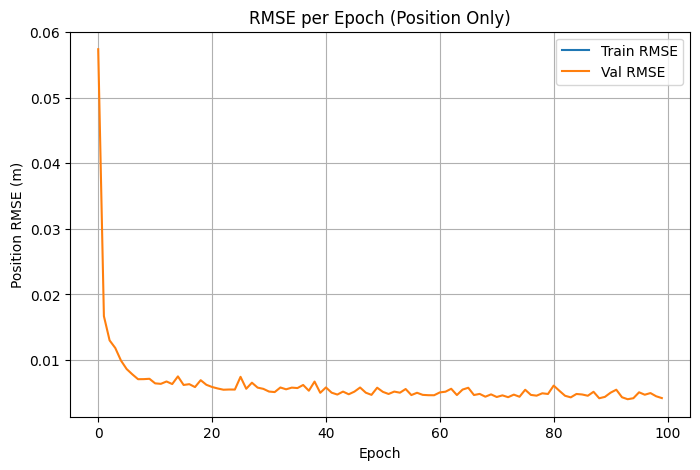

In [22]:
plt.figure(figsize=(8, 5))
plt.plot(rmse_train_pos_epochs, label='Train RMSE')
plt.plot(rmse_val_pos_epochs, label='Val RMSE')
plt.xlabel("Epoch")
plt.ylabel("Position RMSE (m)")
plt.title("RMSE per Epoch (Position Only)")
plt.grid(True)
plt.legend()
plt.show()


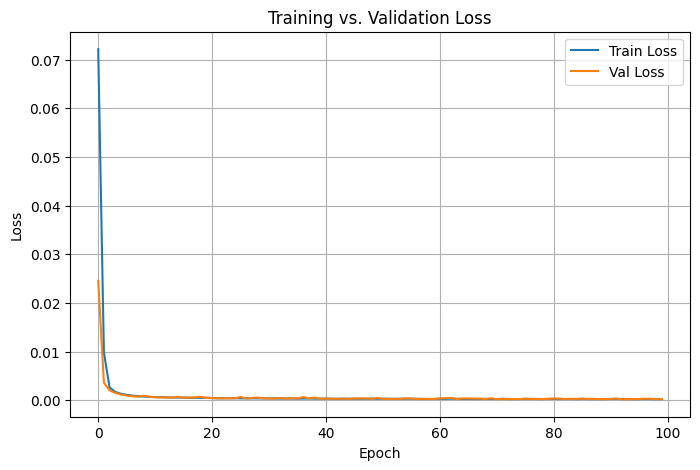

In [23]:
# start from 10th epoch

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.grid(True)
plt.legend()
plt.show()

### Test 

In [24]:
# model.eval()
with torch.no_grad():
    Y_pred_test = model(X_test)
    test_loss = loss_fn(Y_pred_test, Y_test).item()
    print("Test Loss (MSE):", test_loss)

Test Loss (MSE): 0.00023565880837850273


In [25]:
Y_pred_test_original = scaler_Y.inverse_transform(Y_pred_test.numpy())
Y_test_original = scaler_Y.inverse_transform(Y_test.numpy())


# Now compute errors in original units:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(Y_test_original, Y_pred_test_original)
mae = mean_absolute_error(Y_test_original, Y_pred_test_original)

# MSE represents the average of the squares of the errors, which is in original units
# MAE represents the average of the absolute differences, which is also in original units
print("Test MSE (original scale):", mse)
print("Test MAE (original scale):", mae)
# RMSE is the square root of MSE, which is also in original units
print("RMSE (original scale):", np.sqrt(mse))

Test MSE (original scale): 2.4824539650580846e-05
Test MAE (original scale): 0.0029557039961218834
RMSE (original scale): 0.004982423070212008


In [26]:
Y_test_original

array([[ 0.06227309,  0.35601842, -0.20578595, ...,  0.00631158,
         0.76262456, -0.2619525 ],
       [ 0.07327132,  0.3378603 , -0.27668396, ..., -0.10094617,
         0.5755719 , -0.5539695 ],
       [ 0.08124334,  0.34604013, -0.26077038, ..., -0.01028893,
         0.5740061 , -0.5813979 ],
       ...,
       [ 0.06712858,  0.3406202 , -0.27027392, ..., -0.06806015,
         0.6205578 , -0.5396176 ],
       [ 0.08335324,  0.35520485, -0.15832734, ...,  0.20471945,
         0.6985363 ,  0.03549118],
       [ 0.01482544,  0.341405  , -0.23619983, ..., -0.3060484 ,
         0.5848139 , -0.32133594]], shape=(1800, 9), dtype=float32)

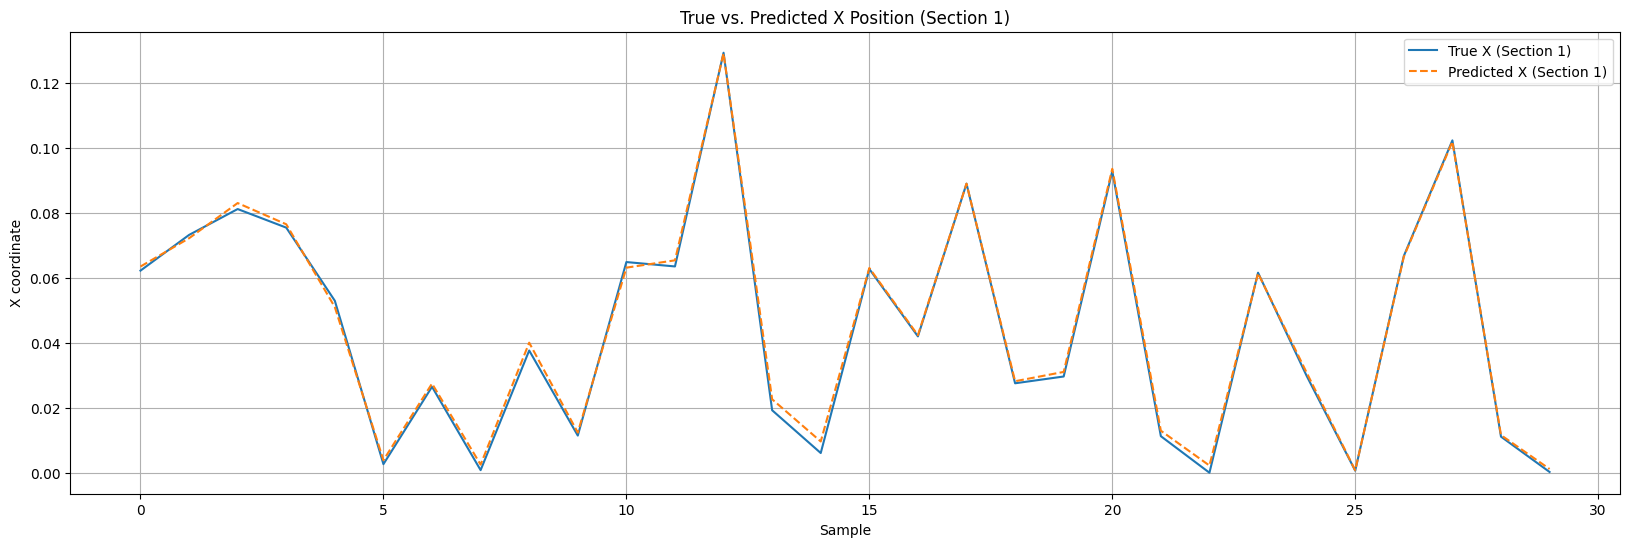

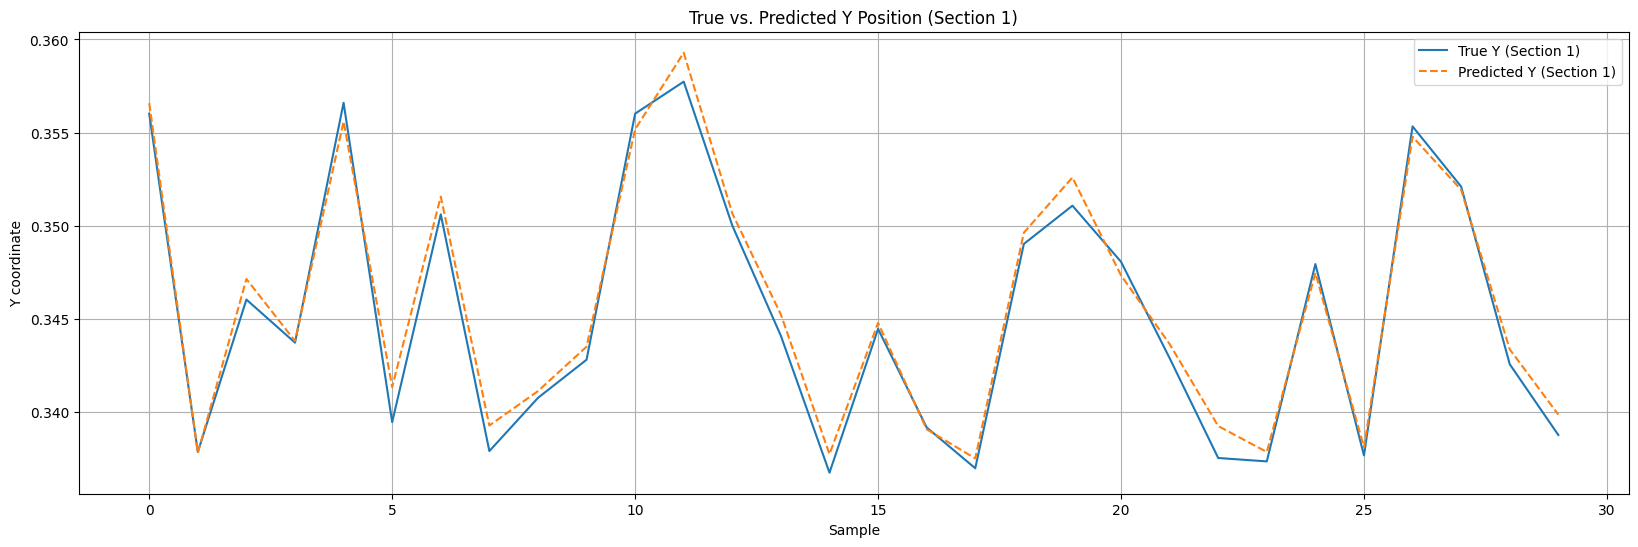

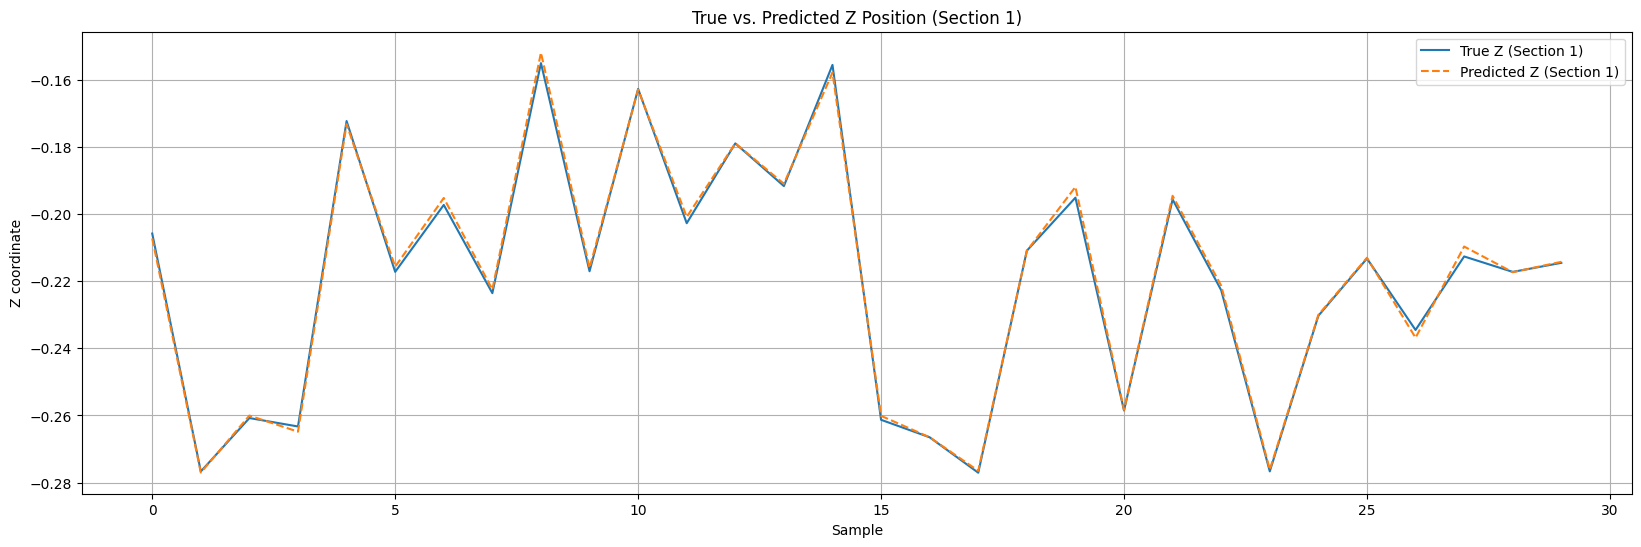

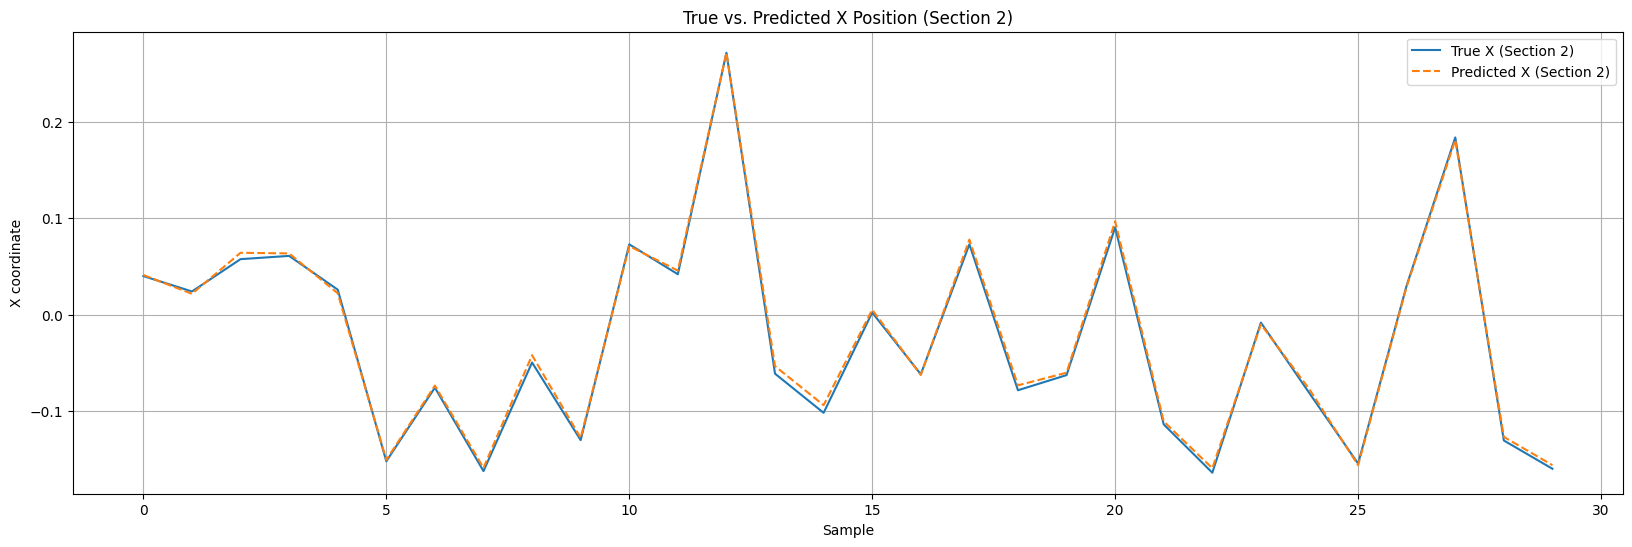

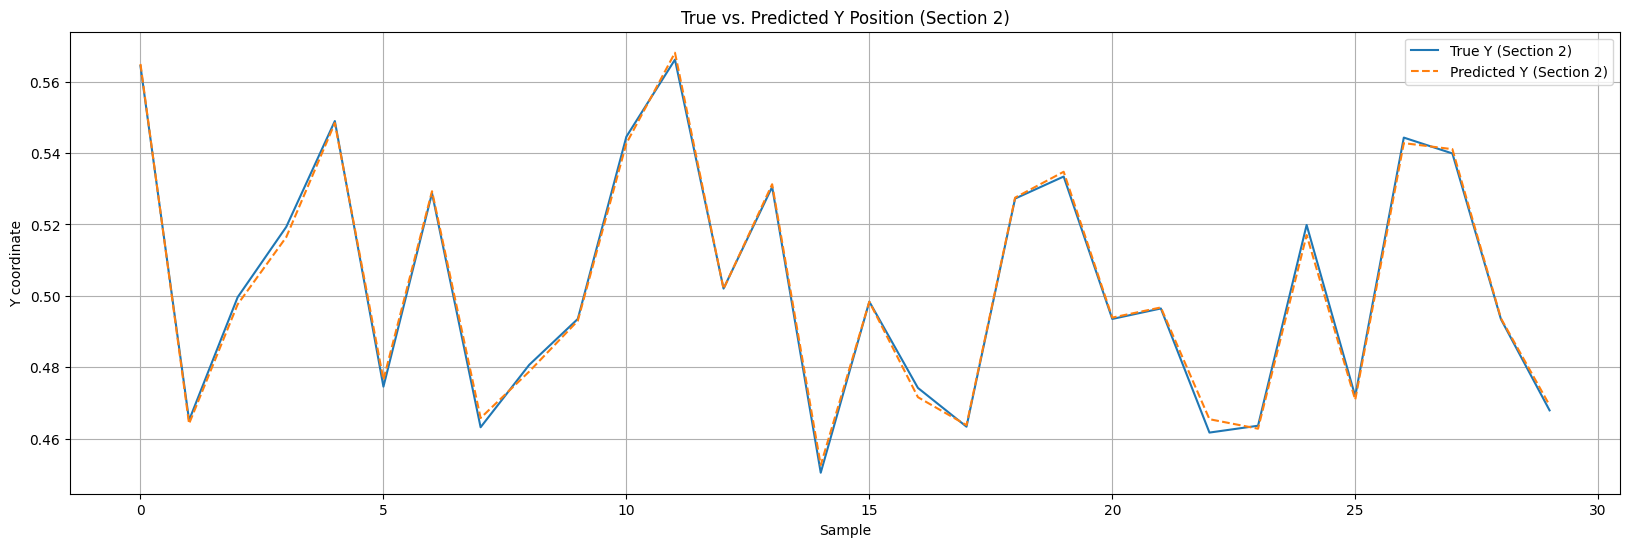

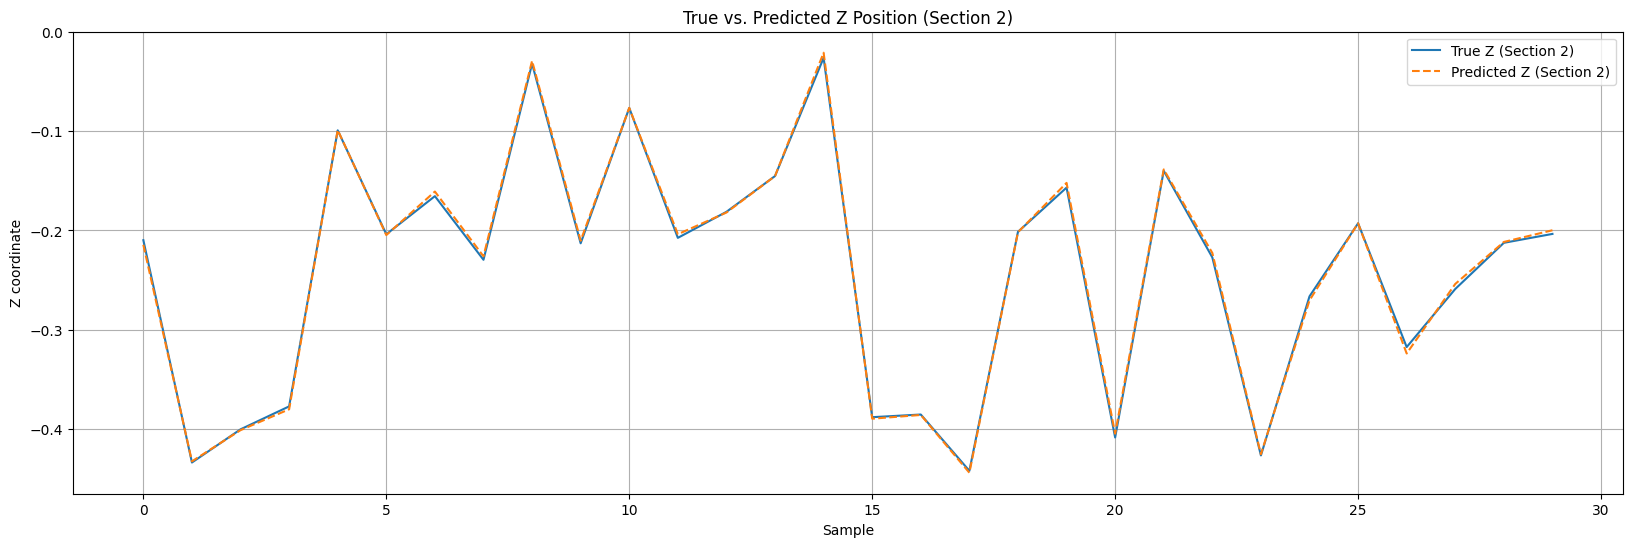

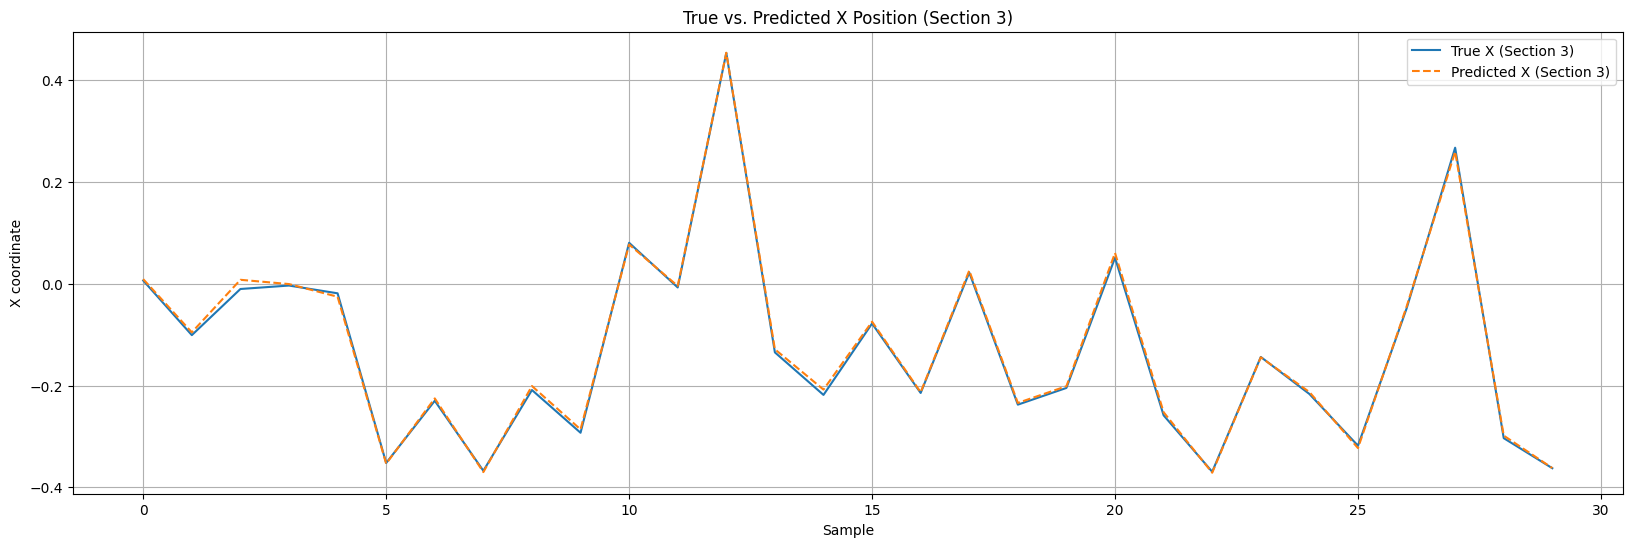

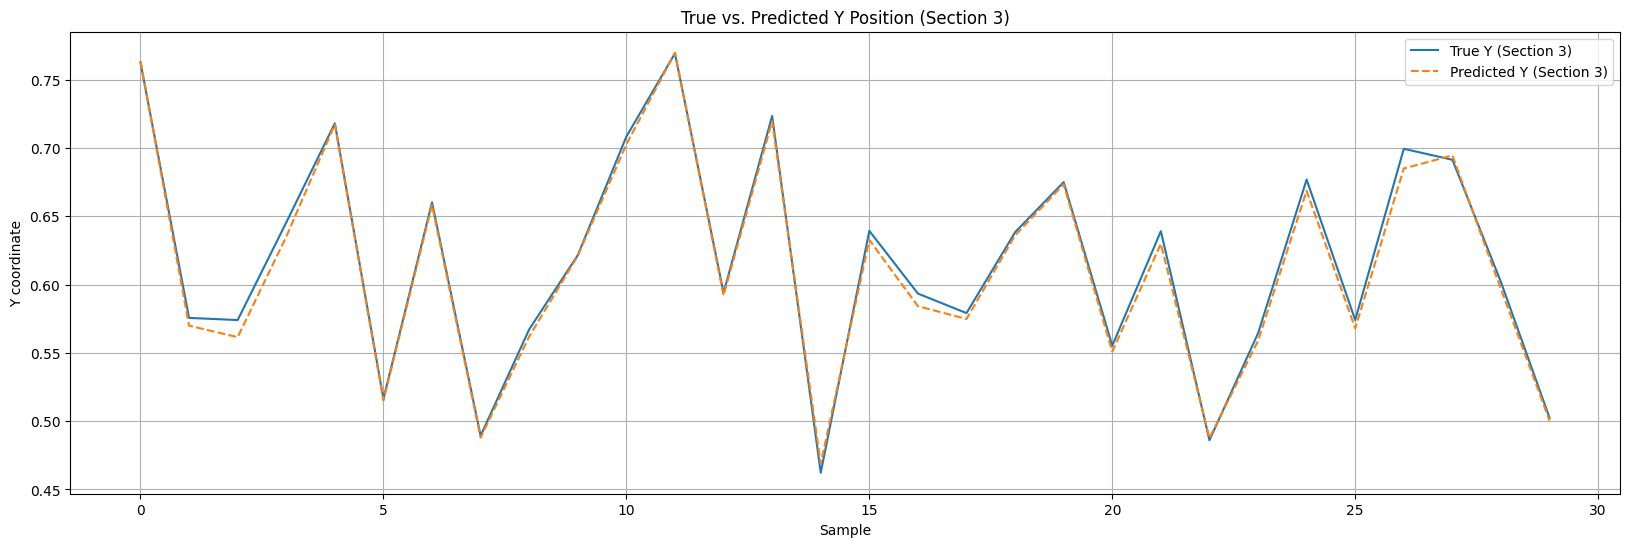

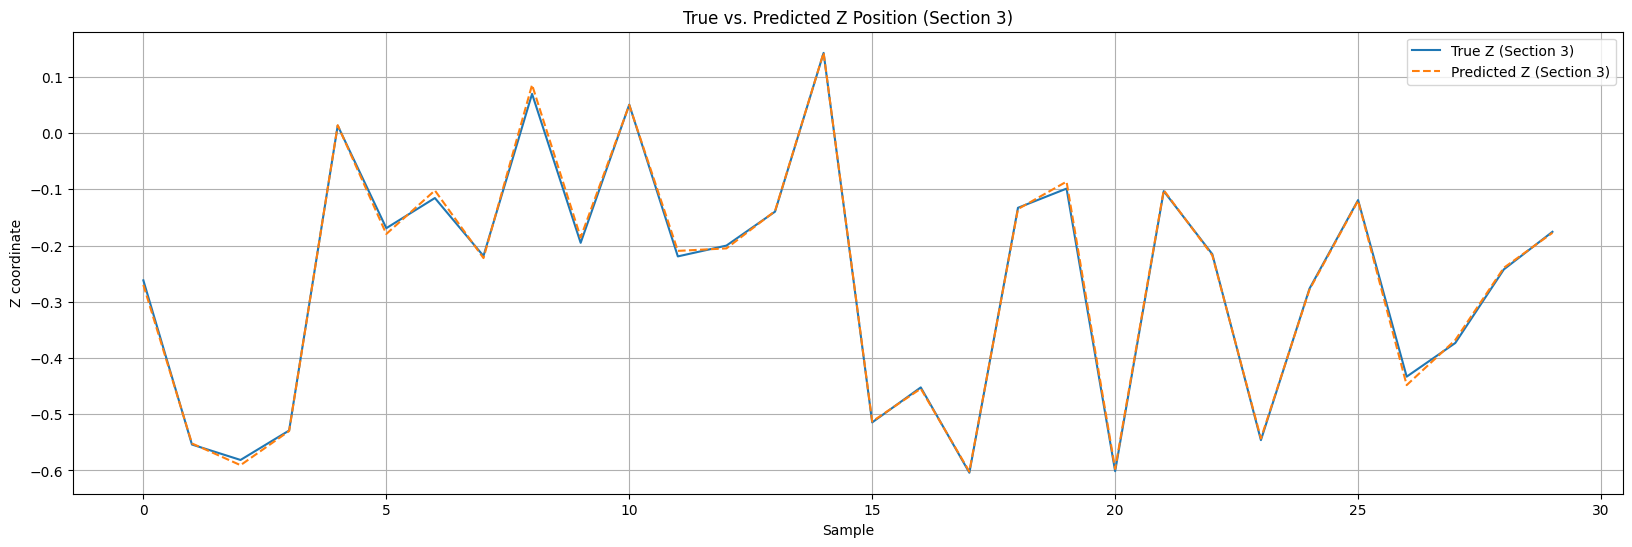

In [27]:
sections = {
    "Section 1": 0,  # Low
    "Section 2": 3,  # Middle
    "Section 3": 6   # Up / End Effector
}

coords = ['X', 'Y', 'Z']

for section_name, start_idx in sections.items():
    for i, coord in enumerate(coords):
        plt.figure(figsize=(20, 6))
        plt.plot(Y_test_original[:30, start_idx + i], label=f'True {coord} ({section_name})')
        plt.plot(Y_pred_test_original[:30, start_idx + i], label=f'Predicted {coord} ({section_name})', linestyle='--')
        plt.legend()
        plt.xlabel('Sample')
        plt.ylabel(f'{coord} coordinate')
        plt.title(f'True vs. Predicted {coord} Position ({section_name})')
        plt.grid()
        plt.show()


In [34]:
# Show mean and std of the errors of each section low, middle and up
Y_test_original = Y_test_original.reshape(-1, 9)
Y_pred_test_original = Y_pred_test_original.reshape(-1, 9)

import numpy as np
# Calculate mean and std of the errors for each section
mean_errors = {
    "Section 1": np.mean(np.abs(Y_test_original[:, 0:3] - Y_pred_test_original[:, 0:3]), axis=0),
    "Section 2": np.mean(np.abs(Y_test_original[:, 3:6] - Y_pred_test_original[:, 3:6]), axis=0),
    "Section 3": np.mean(np.abs(Y_test_original[:, 6:9] - Y_pred_test_original[:, 6:9]), axis=0)
}
print("Mean Errors (absolute):")
for section, mean_error in mean_errors.items():
    print(f"{section}: {mean_error}")

Mean Errors (absolute):
Section 1: [0.00104489 0.00089542 0.00111292]
Section 2: [0.00269411 0.00152284 0.00244981]
Section 3: [0.00610769 0.00493374 0.00583992]


In [28]:
# Create a 3D scatter plot of the predicted positions
# Of all 3 sections (low, middle, up)
import plotly.graph_objects as go

fig = go.Figure()

for section_name, start_idx in sections.items():
    fig.add_trace(go.Scatter3d(
        x=Y_test_original[:30, start_idx], y=Y_test_original[:, start_idx + 1], z=Y_test_original[:, start_idx + 2],
        mode='markers',
        name=f'True Position {section_name}',
        marker=dict(size=2, opacity=0.8)
    ))

    fig.add_trace(go.Scatter3d(
        x=Y_pred_test_original[:30, start_idx], y=Y_pred_test_original[:, start_idx + 1], z=Y_pred_test_original[:, start_idx + 2],
        mode='markers',
        name=f'Predicted Position {section_name}',
        marker=dict(size=2, opacity=0.8)
    ))
    
# Set the layout of the plot
fig.update_layout(
    title='3D Scatter Plot of True vs. Predicted Positions',
    scene=dict(
        xaxis_title='X Coordinate',
        yaxis_title='Y Coordinate',
        zaxis_title='Z Coordinate'
    ),
    
    margin=dict(l=0, r=0, b=0, t=40),
    legend=dict(itemsizing='constant', bgcolor="rgba(255,255,255,0.8)")
)

fig.show()

In [31]:
import numpy as np
import plotly.graph_objects as go

# Assuming you already have these variables defined:
# Y_test_original, Y_pred_test_original

sections = {"low": 0, "middle": 3, "up": 6}
num_movements = 50  # Limit to 10 movements (positions)

fig = go.Figure()

# Colors for ground truth points
gt_colors = {"low": "blue", "middle": "green", "up": "red"}

all_pred_x, all_pred_y, all_pred_z, all_errors = [], [], [], []

for section_name, start_idx in sections.items():

    # True positions
    true_xyz = Y_test_original[:num_movements, start_idx:start_idx + 3]
    pred_xyz = Y_pred_test_original[:num_movements, start_idx:start_idx + 3]

    # Calculate distance errors
    errors = np.linalg.norm(true_xyz - pred_xyz, axis=1)

    all_pred_x.extend(pred_xyz[:, 0])
    all_pred_y.extend(pred_xyz[:, 1])
    all_pred_z.extend(pred_xyz[:, 2])
    all_errors.extend(errors)

    # Plot true positions
    fig.add_trace(go.Scatter3d(
        x=true_xyz[:, 0], y=true_xyz[:, 1], z=true_xyz[:, 2],
        mode='markers',
        marker=dict(size=5, color=gt_colors[section_name], symbol='square'),
        name=f'True {section_name}'
    ))

    # Add dashed lines between predicted and true points
    for j in range(num_movements):
        fig.add_trace(go.Scatter3d(
            x=[pred_xyz[j, 0], true_xyz[j, 0]],
            y=[pred_xyz[j, 1], true_xyz[j, 1]],
            z=[pred_xyz[j, 2], true_xyz[j, 2]],
            mode='lines',
            line=dict(width=1, color='gray', dash='dot'),
            showlegend=False
        ))

# Predicted points with color indicating error
fig.add_trace(go.Scatter3d(
    x=all_pred_x,
    y=all_pred_y,
    z=all_pred_z,
    mode='markers',
    marker=dict(
        size=5,
        color=all_errors,
        colorscale='Viridis',
        colorbar=dict(
            title='Prediction Error<br>(distance in meters)',
            len=0.75,
            thickness=15
        ),
        showscale=True
    ),
    name='Predicted positions'
))

# Update the layout
fig.update_layout(
    title='3D Scatter Plot of Predicted vs True Positions (Errors Highlighted) - 50 Movements',
    scene=dict(
        xaxis_title='X Coordinate',
        yaxis_title='Z Coordinate',
        zaxis_title='Y Coordinate'
    ),
    margin=dict(l=0, r=0, b=0, t=40),
    legend=dict(
        x=0,
        y=1,
        xanchor='left',
        yanchor='top',
        bgcolor="rgba(255,255,255,0.8)",
        itemsizing='constant'
    )
)

fig.show()


In [41]:
version = 9000
# Save the model
model_path = f"kinematic_model_v{version}_2.pth"
torch.save(model.state_dict(), model_path)

# Also save the scalers for reuse later
import joblib
joblib.dump(scaler_X, f"scaler_X_{version}_2.save")
joblib.dump(scaler_Y, f"scaler_Y_{version}_2.save")

print("Model and scalers saved!")

Model and scalers saved!
